In [2]:
import pandas as pd
import numpy as np
import re
import requests
import datetime
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ambiance

In [3]:
def read_xls(file, sheet):
    
    try:
        df = pd.read_excel(file,sheet)
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [4]:
def read_csv(file):
    
    try:
        df = pd.read_csv(file, sep=' ')
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [5]:
def calculate_bearing(d):
  dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
  ix = int(round(d / (360. / len(dirs))))
    
  return dirs[ix % len(dirs)]

In [6]:
def convert_lat_gps_coord(coor):
    
    lat_deg = coor[:2]
    lat_min = coor[2:4]
    lat_sec = coor[5:7]
    direction = coor[7]
    
    dd = (float(lat_deg) + float(lat_min)/60 + float(lat_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

    return dd

In [7]:
def convert_lon_gps_coord(coor):
    
    lon_deg = coor[1:3]
    lon_min = coor[3:5]
    lon_sec = coor[6:8]
    direction = coor[8]
    
    dd = (float(lon_deg) + float(lon_min)/60 + float(lon_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    
    return dd

In [66]:
def plot(lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Pays de Gex', 
             width=bokeh_width, height=bokeh_height)
    # definition of the column data source: 
    source = ColumnDataSource(df)
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center = p.circle('lon', 'lat', size=4, alpha=0.2, 
                      color='yellow', source=source)
    show(p)
    return p

In [67]:
def Alt_toPressure(val):

    return ambiance.Atmosphere(val).pressure[0]

In [68]:
def Alt_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere(val).temperature)[0]

In [69]:
def Alt_toLayerName(val):
    
    return ambiance.Atmosphere(val).layer_name[0]

In [70]:
def Pressure_toAlt(val):
    
    return ambiance.Atmosphere.from_pressure(val).h[0]

In [71]:
def Pressure_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere.from_pressure(val).temperature)[0]

### Read Input Telemetry Spreadsheet

In [73]:
df = read_xls("KW9D-11 APRS Raw Packets.xlsx","Telemetry")

In [74]:
df.sample(10)

Date      Time    TZ                                  Path GPS Time  \
61  2022-04-29  11:48:27  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  164822h   
118 2022-04-29  13:24:26  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  182420h   
110 2022-04-29  13:02:49  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  180243h   
9   2022-04-29  10:33:56  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  153350h   
43  2022-04-29  11:23:18  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:  162312h   
116 2022-04-29  13:22:02  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:  182156h   
107 2022-04-29  12:58:01  CDT:   KW9D-11>APLIGA,WIDE2-1,qAR,KI0EB-6:  175755h   
24  2022-04-29  10:54:20  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:  155414h   
44  2022-04-29  11:24:30  CDT:    KW9D-11>APLIGA,WIDE2-1,qAR,K9MQ-1:  162424h   
113 2022-04-29  13:07:37  CDT:  KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  180731h   

     GPS Epoch  GPS Time Delta (sec)       Lat        Lon Bearing  ...  \
61       60502                    71  4030.93N  08815.20W    O150  ...   
118      66260                    72  4031.76N  08806.15W    O112  ...   
110      64963                    72  4032.63N  08813.98W    O276  ...   
9        56030                    72  4037.25N  08856.59W    O012  ...   
43       58992                    72  4035.42N  08830.58W    O112  ...   
116      66116                   144  4031.91N  08807.65W    O087  ...   
107      64675                    72  4032.31N  08814.55W    O021  ...   
24       57254                    72  4040.09N  08852.07W    O112  ...   
44       59064                    72  4034.71N  08829.17W    O124  ...   
113      65251                    72  4033.02N  08813.67W    O109  ...   

     Ascent Speed (fps)  Ascent Speed (mps)    HDOP  Interior Temp ©  \
61             9.521127            2.902039  00146H            13.3C   
118          -41.972222          -12.793133  00250H            15.4C   
110            8.416667            2.565400  00181H            21.6C   
9              7.388889            2.252133  00136H            30.1C   
43             9.208333            2.806700  00338H            19.3C   
116          -46.611111          -14.207067  00693H            17.1C   
107            8.180556            2.493433  00127H            19.8C   
24            10.041667            3.060700  00137H            28.4C   
44            10.888889            3.318933  00177H            18.7C   
113            5.486111            1.672167  00114H            21.8C   

     Interior Temp (F)  Interior Pressure  Exterior Temp (C)  \
61                55.4            54.7hPa              -31.C   
118               59.0            296.hPa              -30.C   
110               69.8            16.7hPa              -2.6C   
9                 86.0            668.hPa              7.24C   
43                66.2            158.hPa              -44.C   
116               62.6            223.hPa              -45.C   
107               66.2            10.9hPa              1.99C   
24                82.4            437.hPa              -8.0C   
44                64.4            149.hPa              -47.C   
113               69.8            11.0hPa              9.02C   

    Exterior Temp (F) Exterior Pressure  Relative Humidity  
61             -23.80           88.7hPa             0.0479  
118            -22.00           351.hPa             0.3300  
110             28.40           12.2hPa             0.0129  
9               44.96           671.hPa             0.3190  
43             -47.20           186.hPa             0.1300  
116            -49.00           270.hPa             0.1370  
107             35.42           13.3hPa             0.0096  
24              17.60           439.hPa             0.3140  
44             -52.60           179.hPa             0.1240  
113             48.20           11.5hPa             0.0029  

[10 rows x 25 columns]

In [75]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity'],
      dtype='object')

In [76]:
df['I Pressure'] = df['Interior Pressure'].str[:4] + '0'
df['I Pressure'] = df['I Pressure'].astype(float)

In [77]:
df['Interior Temp C'] = df['Interior Temp ©'].str[:4].astype(float)

In [78]:
df['E Pressure'] = df['Exterior Pressure'].str[:4] + '0'
df['E Pressure'] = df['E Pressure'].astype(float)

In [79]:
df['Exterior Temp C'] = df['Exterior Temp (C)'].str[:4].astype(float)

In [80]:
df['Time'] = pd.to_datetime(df['GPS Time'].str[:6],format= '%H%M%S' ).dt.time

In [81]:
df['Cardinal Direction'] = df['Bearing'].str[1:].astype(int).apply(calculate_bearing)

In [82]:
df['HDOP (ft)'] = df['HDOP'].str[:5].astype(int)

In [83]:
df['Rate (fps)'] = df['Ascent Speed (fps)'].abs()
df['Rate (m/s)'] = df['Ascent Speed (mps)'].abs()

In [91]:
df['Predict Pressure'] = df['Altitude (m)'].apply(Alt_toPressure)/100

In [92]:
df['Predict Temp(C)'] = df['Altitude (m)'].apply(Alt_toTemp)
df['Predict Temp(F)'] = df['Predict Temp(C)'].astype(float)*(9/5)+32

In [115]:
df['Predict IP Alt(m)'] = pd.Series(df['I Pressure']*100).apply(Pressure_toAlt)
df['Predict IP Alt(ft)'] = pd.Series(df['I Pressure']*100).apply(Pressure_toAlt) * 3.2808399

In [112]:
df['Predict IP Temp(C)'] = pd.Series(df['I Pressure']*100).apply(Pressure_toTemp)
df['Predict IP Temp(F)'] = df['Predict IP Temp(C)']*(9/5)+32

In [125]:
df['Predict EP Alt(m)'] = pd.Series(df['E Pressure']*100).apply(Pressure_toAlt)
df['Predict EP Alt(ft)'] = df['Predict EP Alt(m)'] * 3.2808399

In [114]:
df['Predict EP Temp(C)'] = pd.Series(df['E Pressure']*100).apply(Pressure_toTemp)
df['Predict EP Temp(F)'] = df['Predict EP Temp(C)']*(9/5)+32

### Read International Standard Atmosphere Tables

In [ ]:
isa = read_csv("International Standard Atmosphere Table.txt")

In [ ]:
isa.head(10)

In [ ]:
isa['hpa'] = isa['(N/m2)']/100

In [ ]:
isa['(F)'] = (isa['(◦C)'].str.strip(' ').str.replace('−','-').astype(float)*(9/5))+32

In [ ]:
#isa['GPS Epoch'] = isa['(ft)'].apply(add_epoch)
isa['(ft)'].

In [ ]:
df['Altitude (ft)'].round(decimals=-2)

In [ ]:
isa.sample(5)

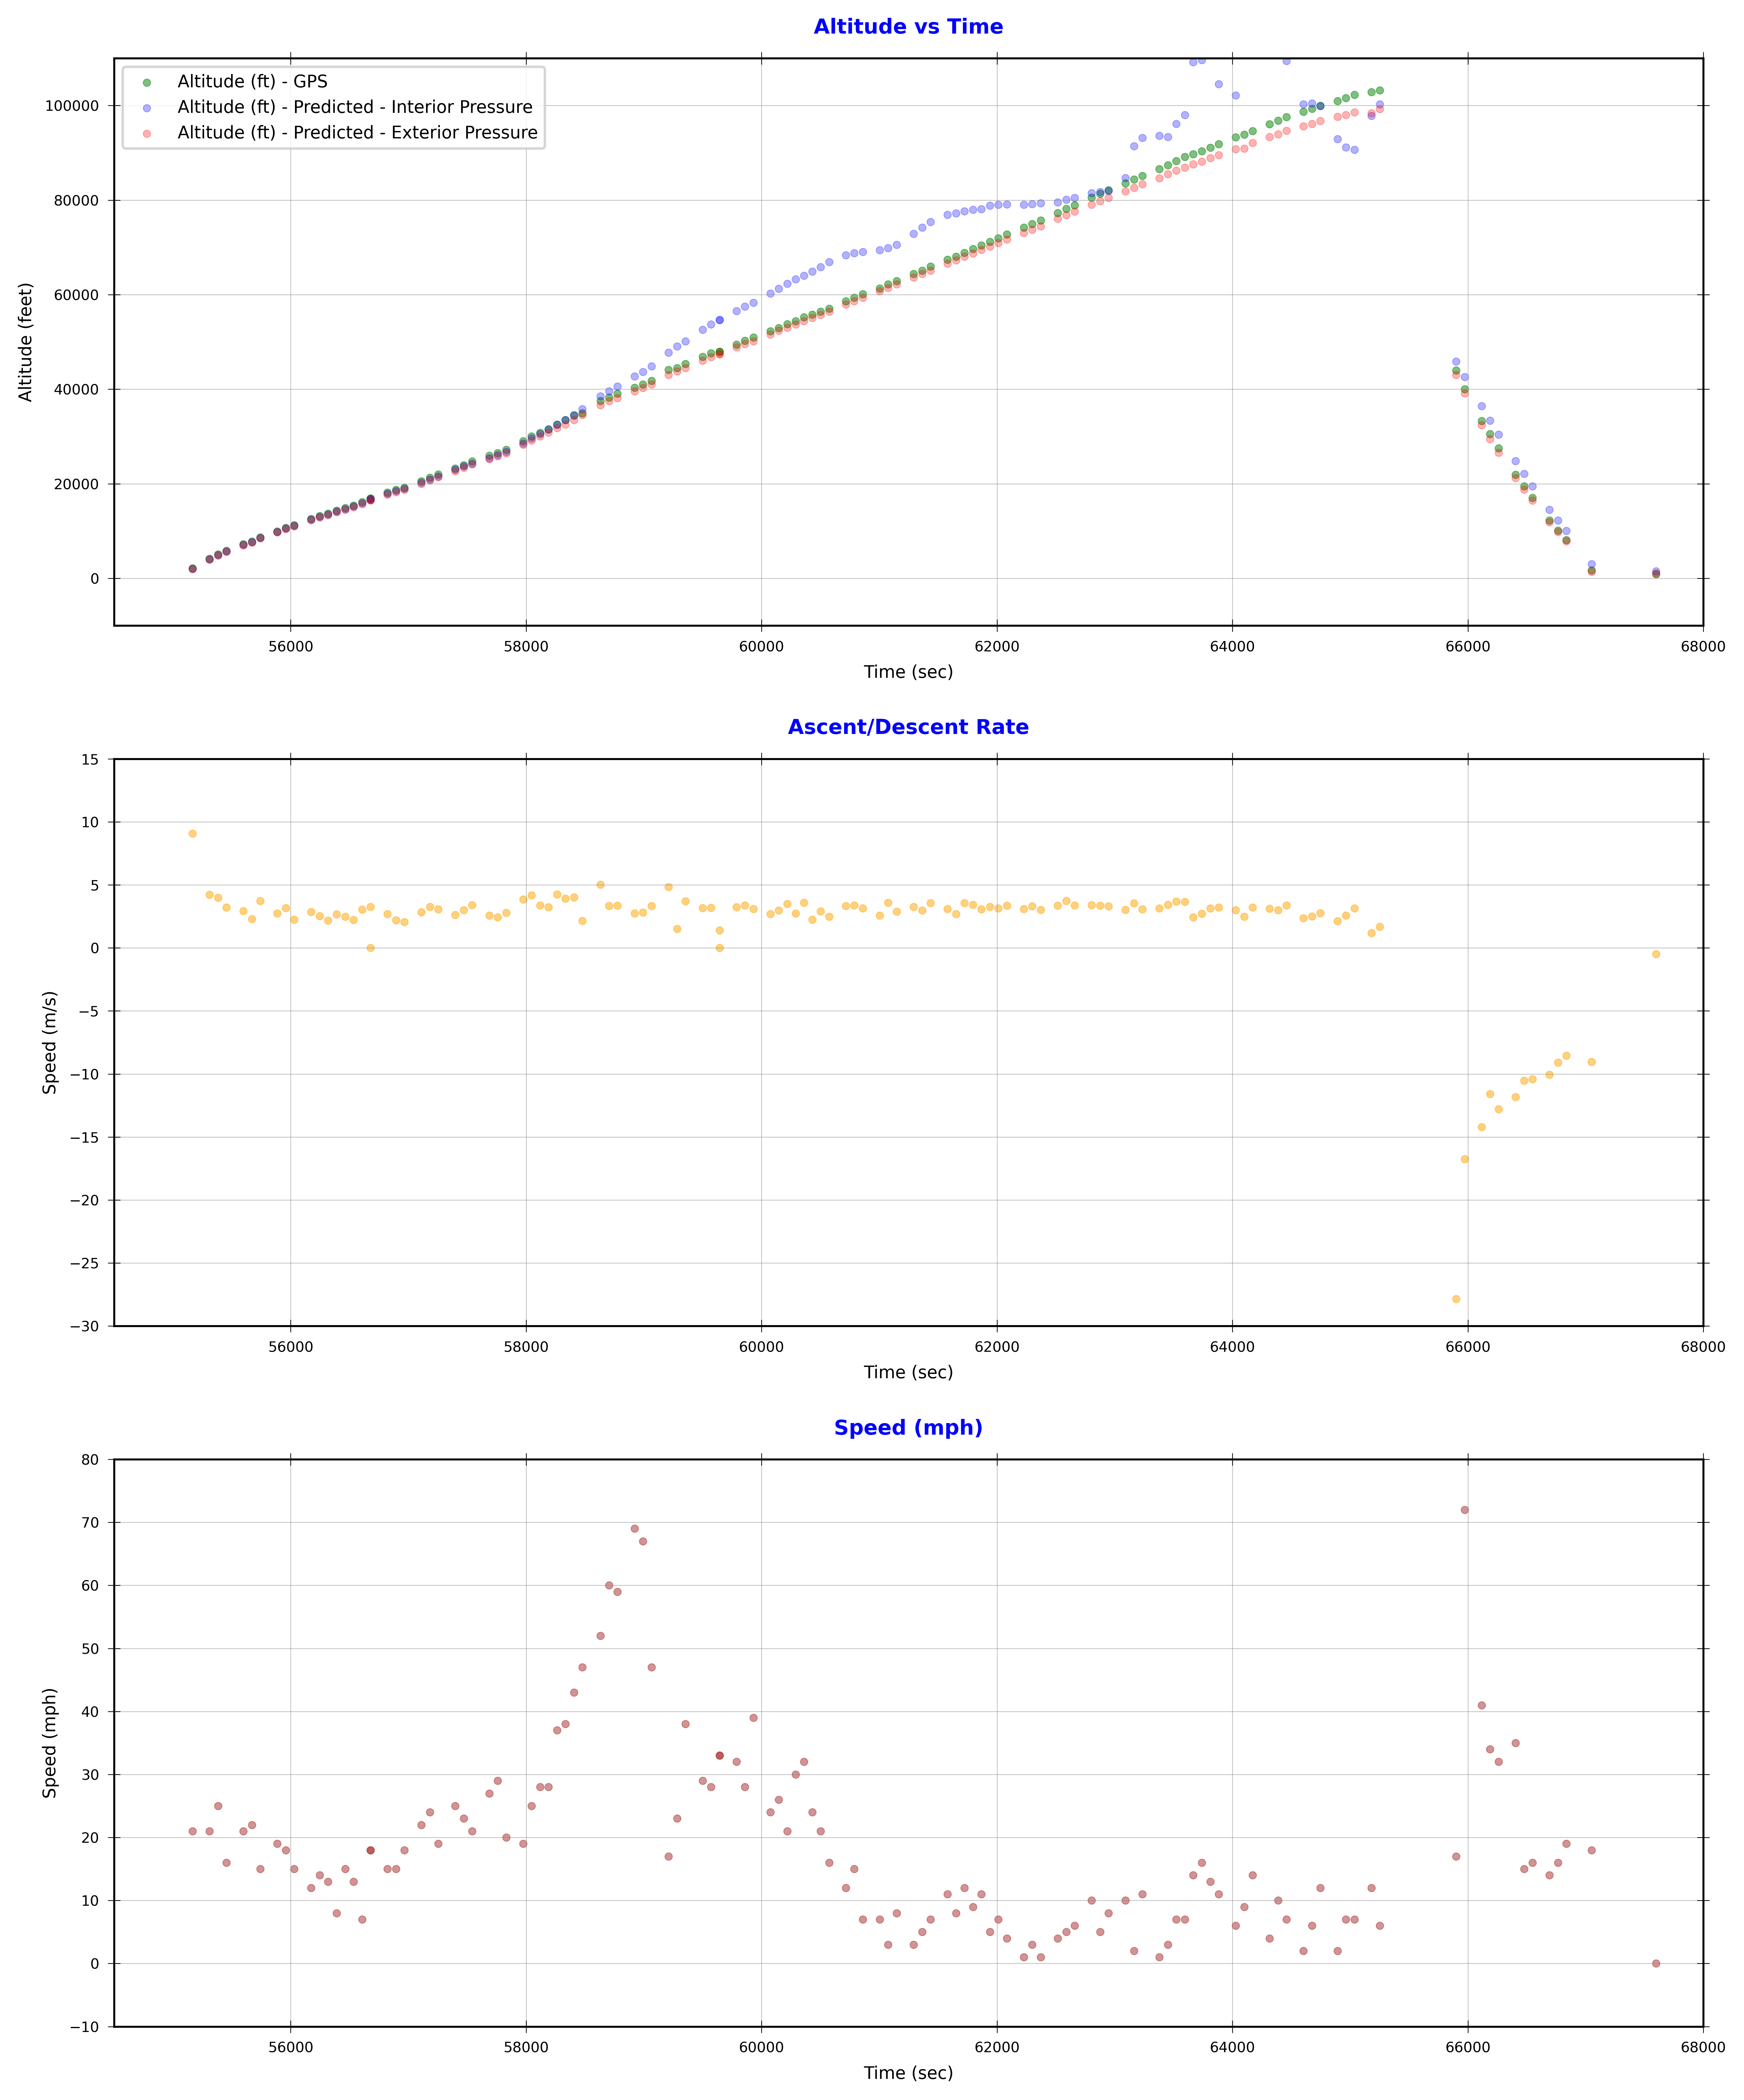

In [124]:
%matplotlib inline

plt.figure(dpi=600, figsize=(10,12))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('GPS Epoch', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot1.scatter('GPS Epoch', 'Predict IP Alt(ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot1.scatter('GPS Epoch', 'Predict EP Alt(ft)', data=df, marker='.', color='red', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (sec)', size='x-small')
plot1.set_ylabel('Altitude (feet)', size='x-small')
plot1.set_title('Altitude vs Time', color='blue', size='small', pad=10.0, weight='bold')
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([-10000,110000])
plot1.set_xlim([54500,68000])
plot1.legend(['Altitude (ft) - GPS', 'Altitude (ft) - Predicted - Interior Pressure', 'Altitude (ft) - Predicted - Exterior Pressure'], fontsize='x-small', loc='upper left')

plot2.scatter('GPS Epoch', 'Ascent Speed (mps)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5,linewidth=0.3)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Time (sec)', size='x-small')
plot2.set_ylabel('Speed (m/s)', size='x-small')
plot2.set_title('Ascent/Descent Rate', color='blue', size='small', pad=10.0, weight='bold')
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([-30,15])
plot2.set_xlim([54500,68000])

plot3.scatter('GPS Epoch', 'Speed (mph)', data=df, marker='.', color='brown', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Time (sec)', size='x-small')
plot3.set_ylabel('Speed (mph)', size='x-small')
plot3.set_title('Speed (mph)', color='blue', size='small', pad=10.0, weight='bold')
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([-10,80])
plot3.set_xlim([54500,68000])

plt.tight_layout(pad=1.5)
plt.show()

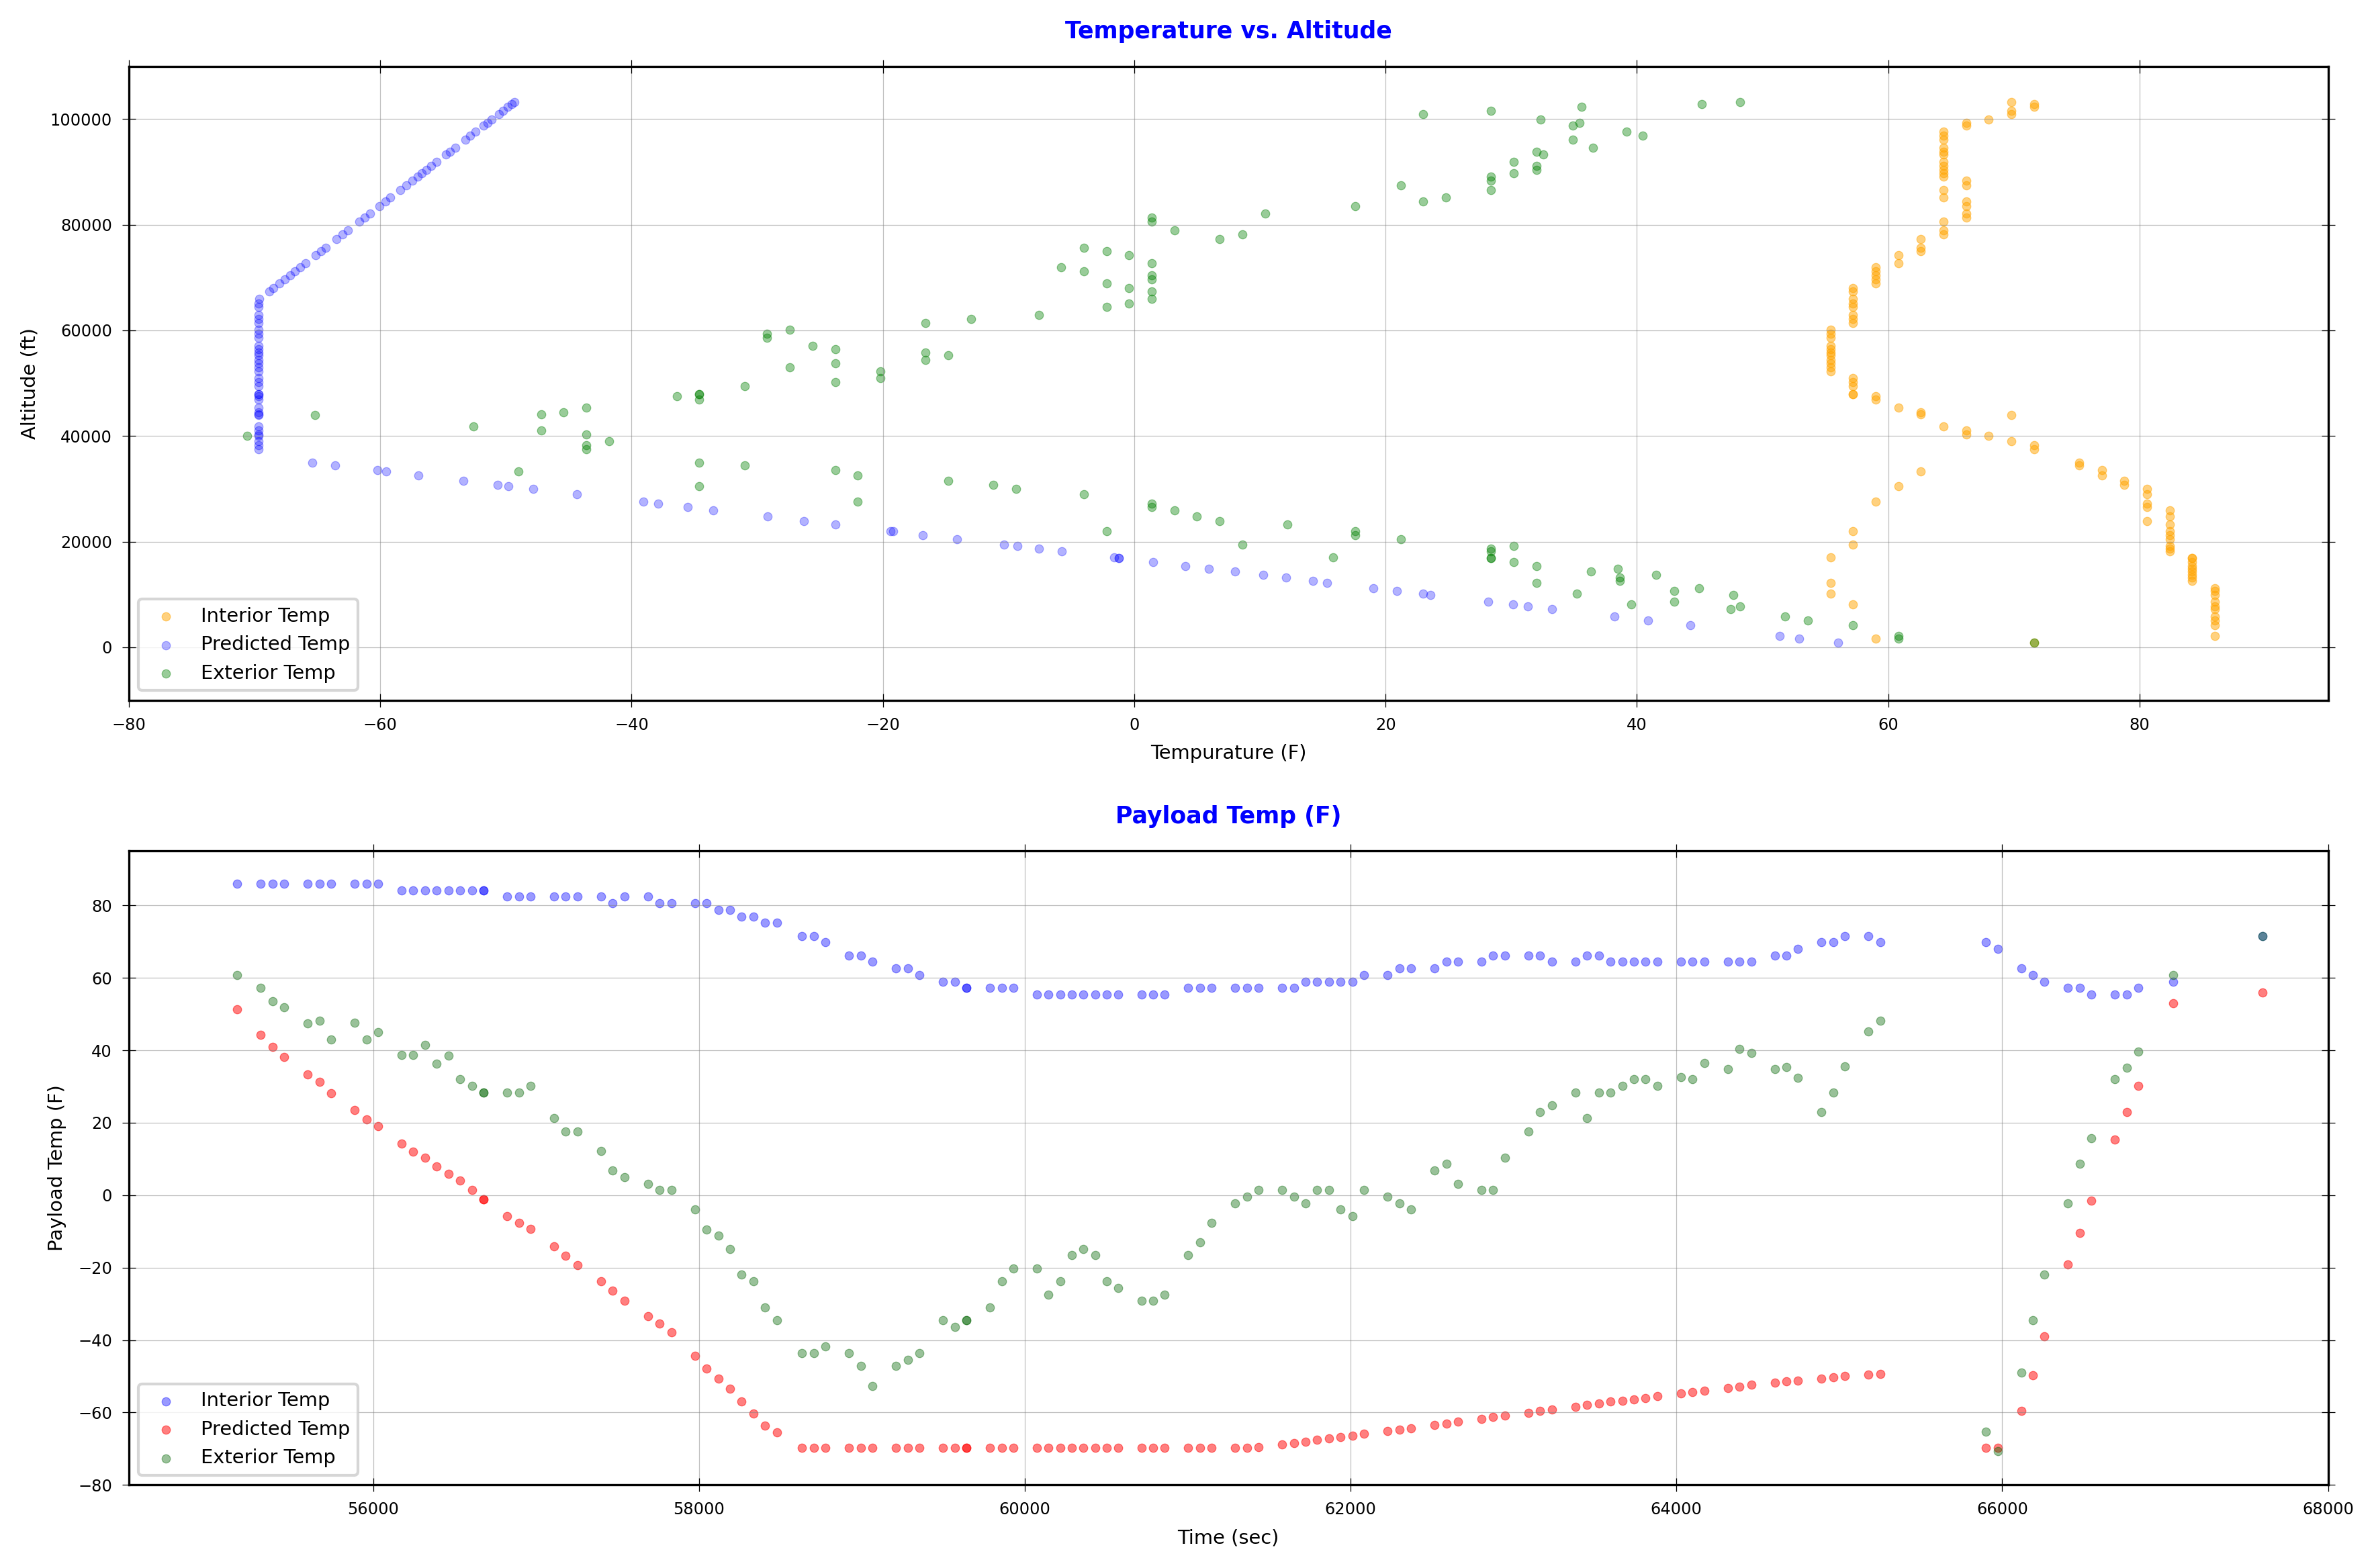

In [131]:
%matplotlib inline

plt.figure(dpi=300, figsize=(12,8))
plot4 = plt.subplot2grid((2,1),(0,0))
plot5 = plt.subplot2grid((2,1),(1,0))

plot4.scatter('Interior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot4.scatter('Predict Temp(F)', 'Altitude (ft)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot4.scatter('Exterior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot4.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot4.set_xlabel('Tempurature (F)', size='x-small')
plot4.set_ylabel('Altitude (ft)', size='x-small')
plot4.set_title('Temperature vs. Altitude', color='blue', size='small', pad=10.0, weight='bold')
plot4.grid(visible=True, which='both', linewidth=0.3)
plot4.set_xlim([-80,95])
plot4.set_ylim([-10000,110000])
plot4.legend(['Interior Temp', 'Predicted Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plot5.scatter('GPS Epoch', 'Interior Temp (F)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Predict Temp(F)', data=df, marker='.', color='red', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Exterior Temp (F)', data=df, marker='.', color='darkgreen', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot5.set_xlabel('Time (sec)', size='x-small')
plot5.set_ylabel('Payload Temp (F)', size='x-small')
plot5.set_title('Payload Temp (F)', color='blue', size='small', pad=10.0, weight='bold')
plot5.grid(visible=True, which='both', linewidth=0.3)
plot5.set_ylim([-80,95])
plot5.set_xlim([54500,68000])
plot5.legend(['Interior Temp', 'Predicted Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plt.tight_layout(pad=1.5)
plt.show()

In [ ]:
df.columns

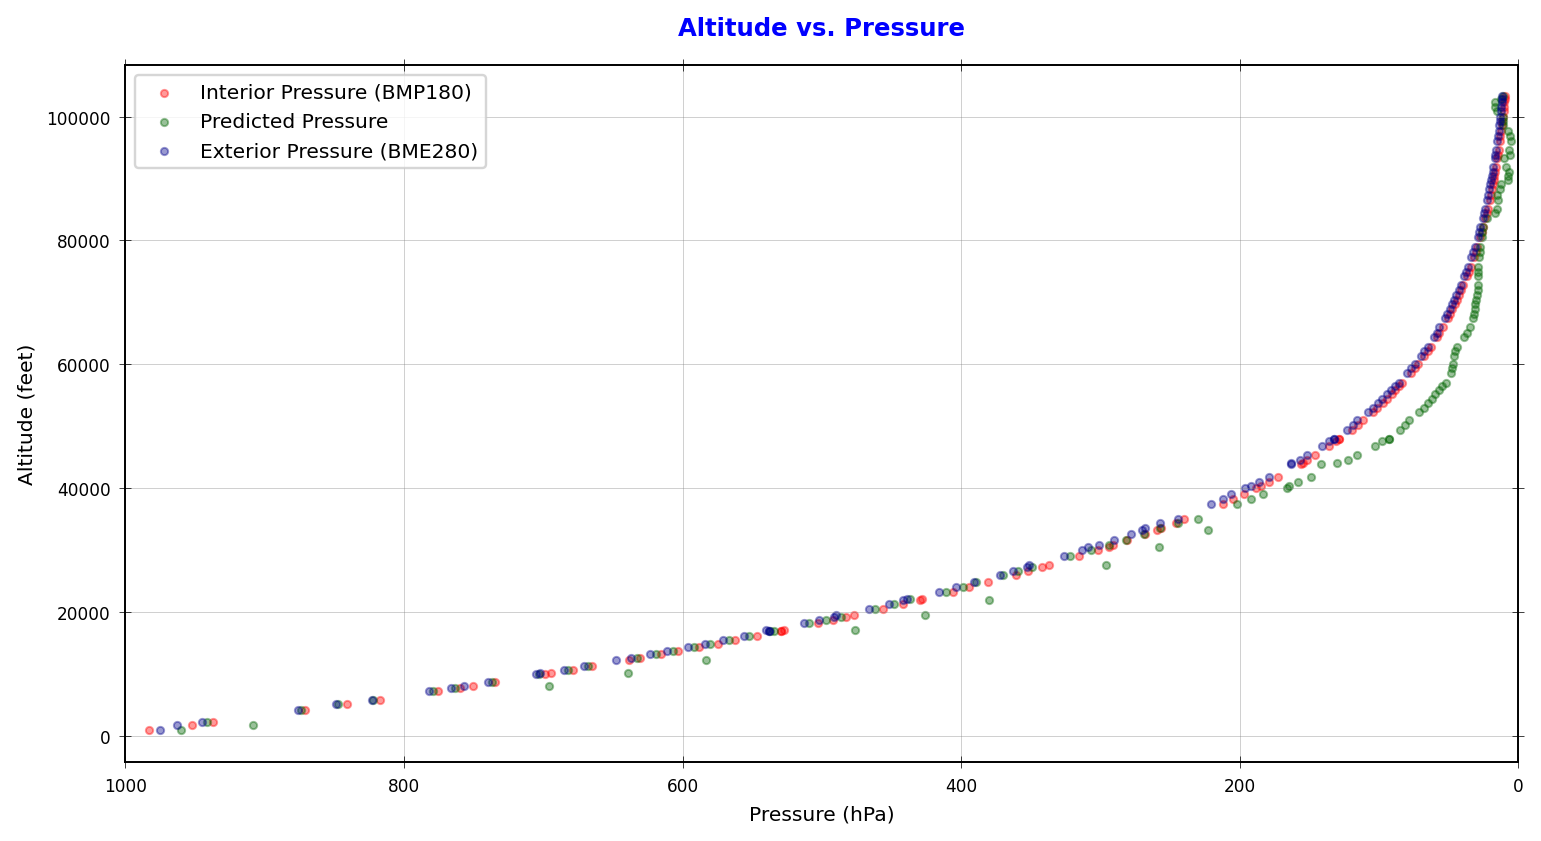

In [137]:
%matplotlib inline

plt.figure(dpi=175, figsize=(10,6))
plot1 = plt.subplot2grid((1,1),(0,0))

plot1.scatter('Predict Pressure', 'Altitude (ft)', marker='.', data=df, color='red', alpha=0.4, linewidth=0.8)
plot1.scatter('I Pressure', 'Altitude (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.scatter('E Pressure', 'Altitude (ft)', marker='.', data=df, color='darkblue', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Altitude (feet)', size='small')
plot1.set_title('Altitude vs. Pressure', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.legend(['Interior Pressure (BMP180)', 'Predicted Pressure', 'Exterior Pressure (BME280)'], fontsize='small', loc='upper left')
plot1.set_xlim([1000,0])

plt.tight_layout(pad=5.0)
plt.show()

In [138]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)',
       'Predict Pressure', 'Predict Temp(C)', 'Predict Temp(F)',
       'Predict Alt(m)', 'Predict P Temp(C)', 'Predict P Temp(F)',
       'Predict P Alt(m)', 'Predict IP Alt(m)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)', 'Predict EP Alt(m)', 'Predict EP Temp(C)',
       'Predict EP Temp(F)', 'Predict IP Alt(ft)', 'Predict EP Alt(ft)'],
      dtype='object')

In [139]:
%matplotlib inline

plt.figure(dpi=800, figsize=(10,10))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('Altitude (ft)', 'HDOP (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Altitude (ft)', size='small')
plot1.set_ylabel('HDOP (ft)', size='small')
plot1.set_title('HDOP vs. Altitude', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('Speed (mph)', 'HDOP (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Speed (mph)', size='small')
plot2.set_ylabel('HDOP (ft)', size='small')
plot2.set_title('HDOP vs. Speed', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot2.grid(visible=True, which='both', linewidth=0.3)

plot3.scatter('Rate (fps)', 'HDOP (ft)', marker='.', data=df, color='orange', alpha=0.5, linewidth=0.8)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Ascent/Descent Rate (fps)', size='small')
plot3.set_ylabel('HDOP (ft)', size='small')
plot3.set_title('HDOP vs. Rate', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot3.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [140]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)',
       'Predict Pressure', 'Predict Temp(C)', 'Predict Temp(F)',
       'Predict Alt(m)', 'Predict P Temp(C)', 'Predict P Temp(F)',
       'Predict P Alt(m)', 'Predict IP Alt(m)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)', 'Predict EP Alt(m)', 'Predict EP Temp(C)',
       'Predict EP Temp(F)', 'Predict IP Alt(ft)', 'Predict EP Alt(ft)'],
      dtype='object')

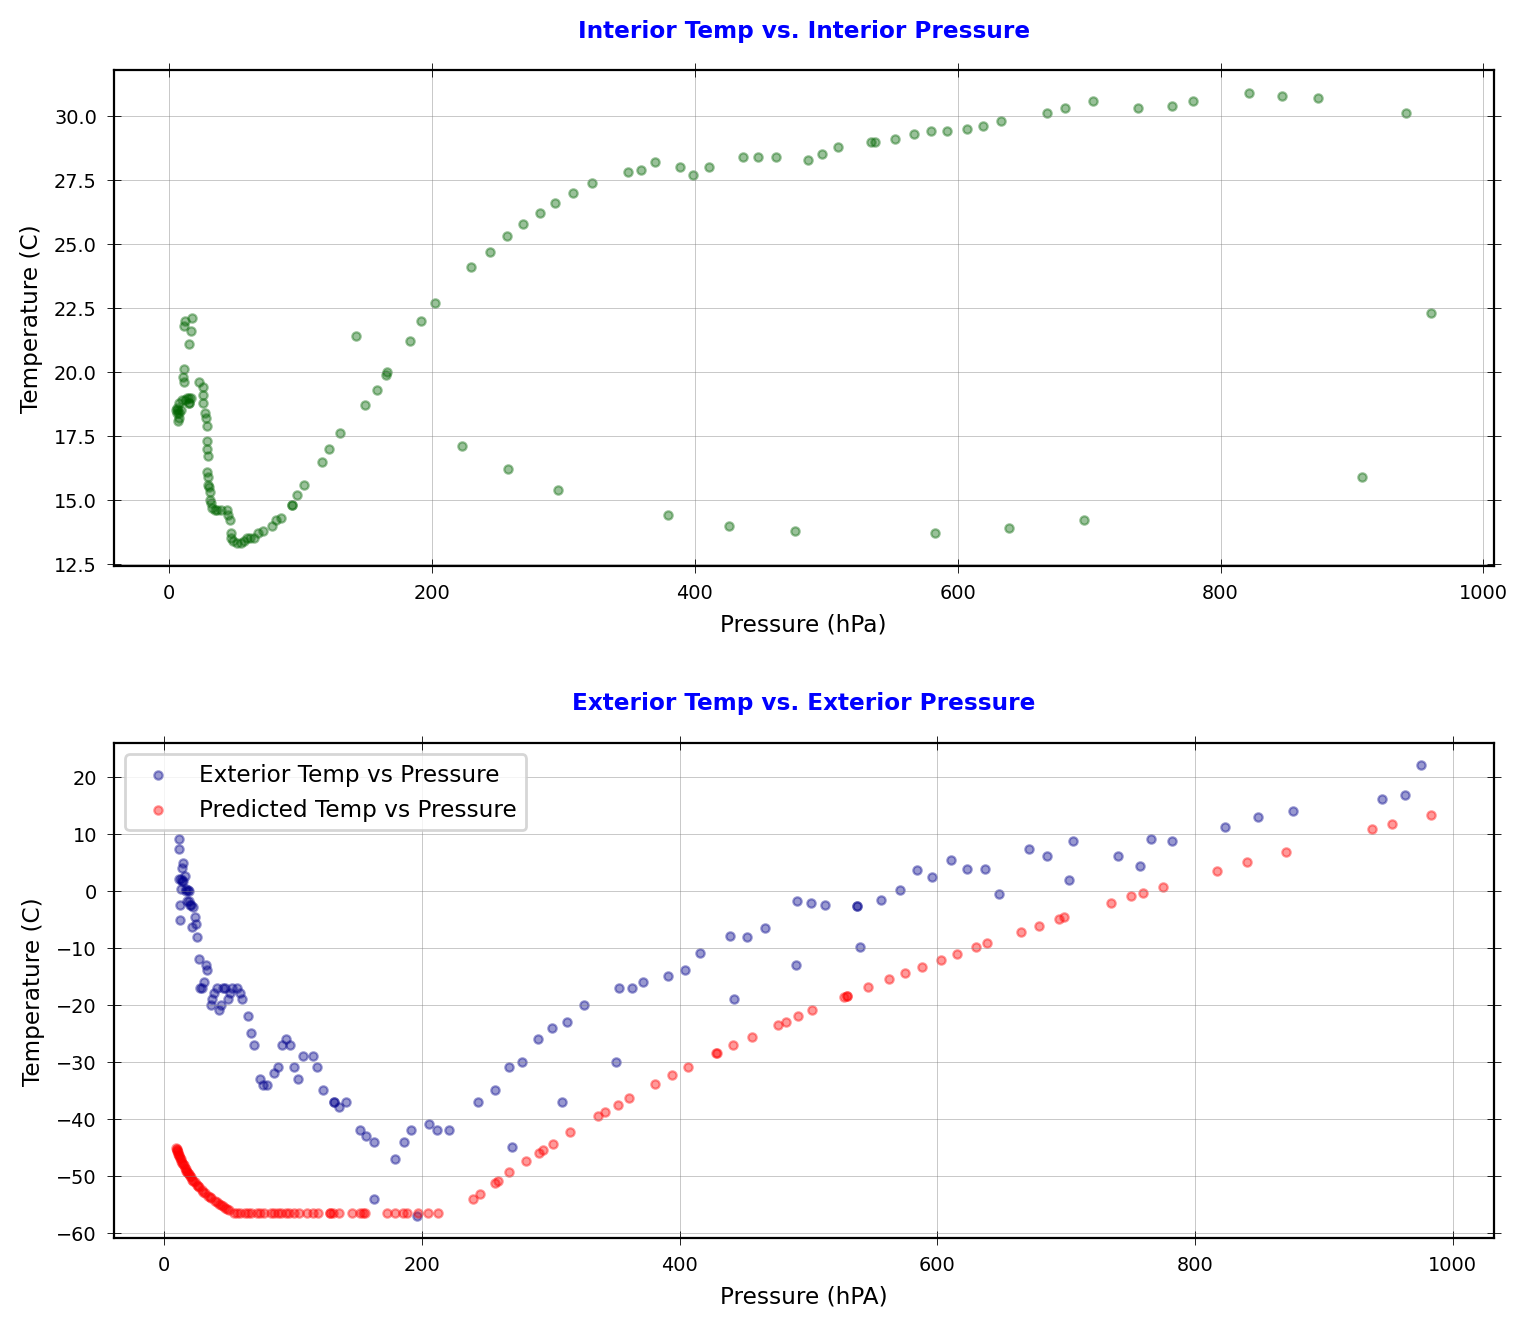

In [153]:
%matplotlib inline

plt.figure(dpi=200, figsize=(8,7))
plot1 = plt.subplot2grid((2,1),(0,0))
plot2 = plt.subplot2grid((2,1),(1,0))

plot1.scatter('I Pressure', 'Interior Temp C', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Temperature (C)', size='small')
plot1.set_title('Interior Temp vs. Interior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('E Pressure', 'Exterior Temp C', marker='.', data=df, color='darkblue', alpha=0.4, linewidth=0.8)
plot2.scatter('Predict Pressure', 'Predict Temp(C)', marker='.', data=df, color='red', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Pressure (hPA)', size='small')
plot2.set_ylabel('Temperature (C)', size='small')
plot2.set_title('Exterior Temp vs. Exterior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot2.legend(['Exterior Temp vs Pressure', 'Predicted Temp vs Pressure'], fontsize='small', loc='upper left')
plot2.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [154]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)',
       'Predict Pressure', 'Predict Temp(C)', 'Predict Temp(F)',
       'Predict Alt(m)', 'Predict P Temp(C)', 'Predict P Temp(F)',
       'Predict P Alt(m)', 'Predict IP Alt(m)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)', 'Predict EP Alt(m)', 'Predict EP Temp(C)',
       'Predict EP Temp(F)', 'Predict IP Alt(ft)', 'Predict EP Alt(ft)'],
      dtype='object')

In [155]:
df.head(5)

Date      Time    TZ                                        Path  \
0 2022-04-29  15:19:26  CDT:  KW9D-11>APLIGA,N9ULL*,WIDE2-1,qAR,N9NWI-1:   
1 2022-04-29  15:21:50  CDT:  KW9D-11>APLIGA,WA9RES,WIDE2*,qAR,KC8RFE-3:   
2 2022-04-29  15:23:02  CDT:        KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:   
3 2022-04-29  15:24:14  CDT:    KW9D-11>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:   
4 2022-04-29  15:26:38  CDT:         KW9D-11>APLIGA,WIDE2-1,qAO,KS9A-10:   

  GPS Time  GPS Epoch  GPS Time Delta (sec)       Lat        Lon Bearing  ...  \
0  151926h      55166                    72  4032.58N  08855.34W    O321  ...   
1  152150h      55310                   144  4033.40N  08856.09W    O319  ...   
2  152302h      55382                    72  4033.78N  08856.36W    O343  ...   
3  152414h      55454                    72  4034.14N  08856.44W    O336  ...   
4  152638h      55598                   144  4034.88N  08856.54W    O355  ...   

   Predict P Temp(F)  Predict P Alt(m)  Predict IP Alt(m)  Predict IP Temp(C)  \
0          51.750990        619.633915         619.633915           10.972772   
1          44.614073       1229.804244        1229.804244            7.007819   
2          41.612268       1486.478455        1486.478455            5.340149   
3          38.762918       1730.135916        1730.135916            3.757177   
4          33.693537       2163.681783        2163.681783            0.940854   

   Predict IP Temp(F)  Predict EP Alt(m)  Predict EP Temp(C)  \
0           51.750990         584.335621           11.202168   
1           44.614073        1211.048803            7.129682   
2           41.612268        1467.239361            5.465145   
3           38.762918        1720.274813            3.821239   
4           33.693537        2132.811761            1.141373   

  Predict EP Temp(F) Predict IP Alt(ft)  Predict EP Alt(ft)  
0          52.163902        2032.919673         1917.111619  
1          44.833428        4034.790834         3973.257235  
2          41.837261        4876.897827         4813.777439  
3          38.878230        5676.298945         5643.946244  
4          34.054472        7098.693526         6997.413925  

[5 rows x 48 columns]

In [156]:
df['Lat_DD'] = df['Lat'].apply(convert_lat_gps_coord)

In [157]:
df['Lon_DD'] = df['Lon'].apply(convert_lon_gps_coord)

In [158]:
df.tail(5)

Date      Time    TZ  \
122 2022-04-29  18:31:32  CDT:   
123 2022-04-29  18:32:44  CDT:   
124 2022-04-29  18:33:56  CDT:   
125 2022-04-29  18:37:31  CDT:   
126 2022-04-30  18:46:38  CDT:   

                                                Path GPS Time  GPS Epoch  \
122             KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:  183132h      66692   
123               KW9D-11>APLIGA,WIDE2-1,qAR,W9YB-1:  183244h      66764   
124               KW9D-11>APLIGA,WIDE2-1,qAR,W9YB-1:  183356h      66836   
125     KW9D-11>APLIGA,WA9RES*,WIDE2-1,qAR,KC8RFE-3:  183731h      67051   
126  KW9D-11>APLIGA,N9PE-2,WIDE1,WIDE2*,qAR,N9NWI-1:  184638h      67598   

     GPS Time Delta (sec)       Lat        Lon Bearing  ...  \
122                   144  4032.19N  08803.07W    O018  ...   
123                    72  4032.45N  08802.88W    O014  ...   
124                    72  4032.81N  08802.83W    O001  ...   
125                   215  4034.09N  08803.23W    O292  ...   
126                   547  4028.54N  08856.06W    O265  ...   

     Predict IP Alt(m)  Predict IP Temp(C)  Predict IP Temp(F)  \
122        4428.331574          -13.764117            7.224589   
123        3724.951056           -9.198002           15.443596   
124        3058.678131           -4.871846           23.230677   
125         915.592690            9.049505           48.289108   
126         453.038655           12.055459           53.699825   

     Predict EP Alt(m)  Predict EP Temp(C)  Predict EP Temp(F)  \
122        3616.621588           -8.494673           16.709588   
123        2991.152107           -4.433344           24.019980   
124        2393.061565           -0.549047           31.011716   
125         426.979495           12.224820           54.004675   
126         323.397827           12.898021           55.216438   

     Predict IP Alt(ft) Predict EP Alt(ft)     Lat_DD     Lon_DD  
122        14528.646919       11865.556408  40.538611 -88.051944  
123        12220.968050        9813.491178  40.545833 -88.057778  
124        10035.033253        7851.251865  40.555833 -88.056389  
125         3003.913030        1400.851365  40.569167 -88.056389  
126         1486.347295        1061.016495  40.481667 -88.935000  

[5 rows x 50 columns]

In [159]:
# Drop last row since it's invalid
df.drop(df.tail(1).index,inplace=True)

In [160]:
df.tail(5)

Date      Time    TZ                                          Path  \
121 2022-04-29  18:29:08  CDT:          KW9D-11>APLIGA,WIDE2-1,qAR,W9IPA-11:   
122 2022-04-29  18:31:32  CDT:          KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-3:   
123 2022-04-29  18:32:44  CDT:            KW9D-11>APLIGA,WIDE2-1,qAR,W9YB-1:   
124 2022-04-29  18:33:56  CDT:            KW9D-11>APLIGA,WIDE2-1,qAR,W9YB-1:   
125 2022-04-29  18:37:31  CDT:  KW9D-11>APLIGA,WA9RES*,WIDE2-1,qAR,KC8RFE-3:   

    GPS Time  GPS Epoch  GPS Time Delta (sec)       Lat        Lon Bearing  \
121  182908h      66548                    72  4031.81N  08803.67W    O072   
122  183132h      66692                   144  4032.19N  08803.07W    O018   
123  183244h      66764                    72  4032.45N  08802.88W    O014   
124  183356h      66836                    72  4032.81N  08802.83W    O001   
125  183731h      67051                   215  4034.09N  08803.23W    O292   

     ...  Predict IP Alt(m)  Predict IP Temp(C)  Predict IP Temp(F)  \
121  ...        5941.012948          -23.580527          -10.444948   
122  ...        4428.331574          -13.764117            7.224589   
123  ...        3724.951056           -9.198002           15.443596   
124  ...        3058.678131           -4.871846           23.230677   
125  ...         915.592690            9.049505           48.289108   

     Predict EP Alt(m)  Predict EP Temp(C)  Predict EP Temp(F)  \
121        5006.695709          -17.517910            0.467761   
122        3616.621588           -8.494673           16.709588   
123        2991.152107           -4.433344           24.019980   
124        2393.061565           -0.549047           31.011716   
125         426.979495           12.224820           54.004675   

     Predict IP Alt(ft) Predict EP Alt(ft)     Lat_DD     Lon_DD  
121        19491.512326       16426.167050  40.539167 -88.068611  
122        14528.646919       11865.556408  40.538611 -88.051944  
123        12220.968050        9813.491178  40.545833 -88.057778  
124        10035.033253        7851.251865  40.555833 -88.056389  
125         3003.913030        1400.851365  40.569167 -88.056389  

[5 rows x 50 columns]

In [161]:
mid = int(len(df['Lon_DD'])/2)

In [162]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [163]:
fig = go.Figure(go.Scattermapbox(
    name = 'Flight Path',
    mode = "markers+lines",
    lon = df['Lon_DD'],
    lat = df['Lat_DD'],
    hoverinfo = 'lon+lat',
    hovertemplate =
    "Longitude: %{lon}<br>" +
    "Latitude: %{lat}<br>" + 
    "%{text}",
    text = 'Altitude: ' + df['Altitude (ft)'].astype(str) + ' (ft)<br>Speed:' + df['Speed (mph)'].astype(str) + ' (mph)<br>Ext Temp: ' + df['Exterior Temp (C)'].astype(str) + '<br>Ext Pressure: ' + df['Exterior Pressure'] + '<br>Int Temp: ' + df['Interior Temp ©'].astype(str) + '<br>Int Pressure: ' + df['Interior Pressure'].astype(str),
    marker = dict(
        size = 7,
        opacity = 1.0,
        symbol = 'circle',    
        reversescale = False,
        autocolorscale = False,
        colorscale = scl,
        cmin = 0,
        color = df['Altitude (ft)'], 
        cmax = df['Altitude (ft)'].max(),
        colorbar_title="<b>High Altitude Balloon</b><br>April 29th 2022")))

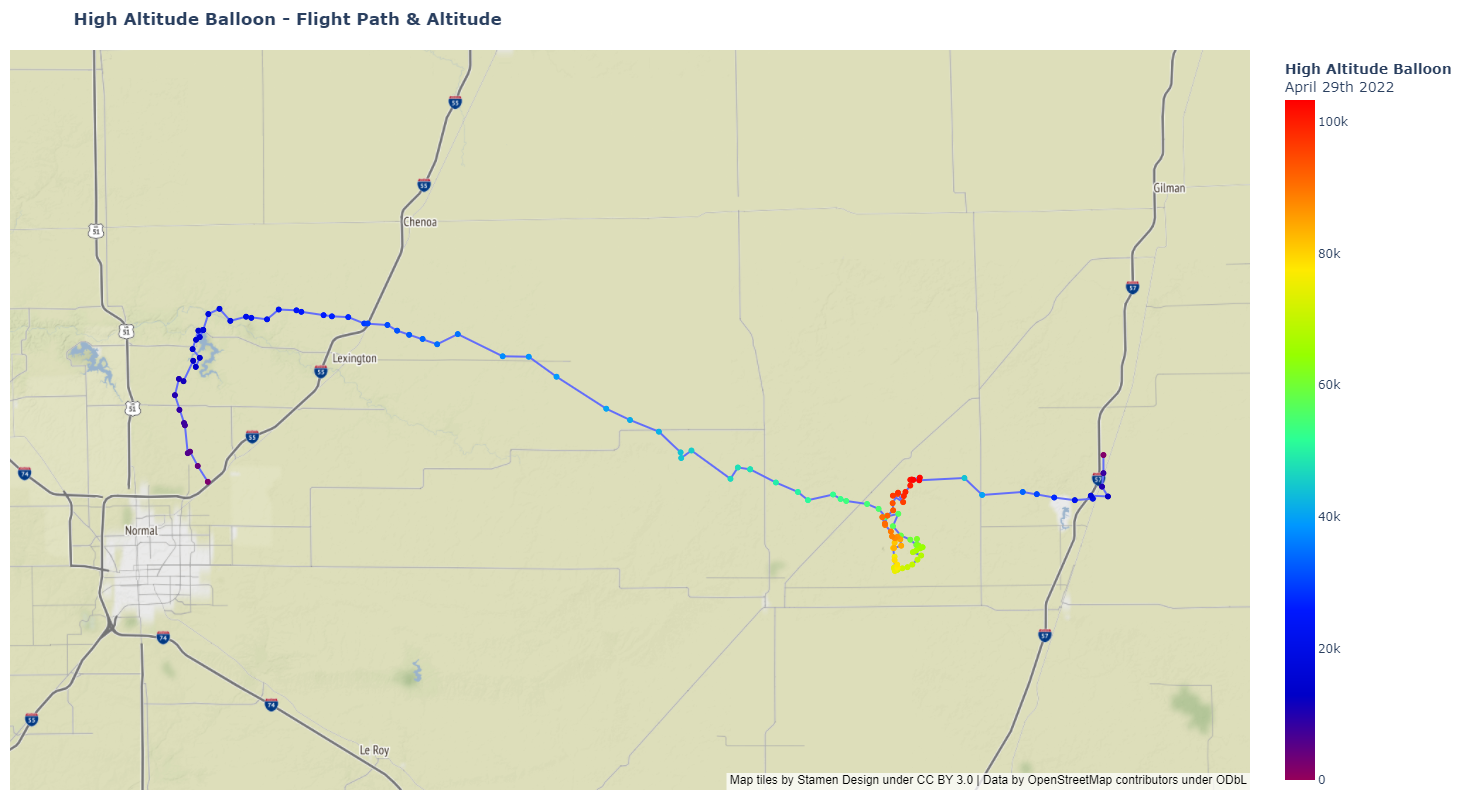

In [164]:
fig.update_layout(
    height = 800,
    width = 1700,
    margin ={'l':10,'t':50,'b':10,'r':10},
    mapbox = {
        'center': {'lon': df['Lon_DD'][mid-20], 'lat': df['Lat_DD'][mid-20]},
        'style': "stamen-terrain",
        'zoom': 9.5,
        })

fig.update_layout(
        title = '<b>High Altitude Balloon - Flight Path & Altitude</b>',
        geo_scope='usa',
        geo = dict(
            scope = 'north america',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'conic conformal',
                rotation_lon = -100
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -140.0, -55.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 20.0, 60.0 ],
                dtick = 5
            )
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        ),
    )

fig.show()